# DSSD分析


## 填充map
要对事件进行时间排序，使用map快速实现

```c++
int DSSD::fillMap() {
	dssdInfo ds;
	printf("filling map   0%%");
	fflush(stdout);
	Long64_t nentry = ipt->GetEntries();
	Long64_t nentry100 = nentry / 100;
	for (Long64_t jentry = 0; jentry != nentry; ++jentry) {
		ipt->GetEntry(jentry);
		ds.Energy = re;
		ds.Strip = rs;
		if (side == 0) mapfs.insert(make_pair(rt, ds));
		else if (side == 1) mapbs.insert(make_pair(rt, ds));

		if (jentry % nentry100 == 0) {
			printf("\b\b\b\b%3lld%%", (jentry+1)/nentry100);
			fflush(stdout);
		}
	}
	printf("\b\b\b\b100%%\n");


	auto ift = mapfs.begin();
	auto ibt = mapbs.begin();
	TH2D *heRaw = new TH2D("heRaw", "front-back correlation raw", 3000, 0, 30000, 3000, 0, 30000);
	int msize = mapfs.size();
	msize = msize < (int)mapbs.size() ? msize : (int)mapbs.size();
	for (int i = 0; i != msize; ++i) {
		heRaw->Fill(ift->second.Energy, ibt->second.Energy);
		++ift;
		++ibt;
	}
	heRaw->Write();
	return 0;
}
```


## 搜索时间窗

通过开足够大的时间窗，观察大部分事件的符合时间的偏移和宽度，以确定正背面符合的时间范围。

```c++
int DSSD::searchWindow(ULong64_t tw, ULong64_t toff) {
	TH1I *hdt = new TH1I("hdt", "ft-bt distribution(ns)", 20000, -100000, 100000);
	for (auto ift = mapfs.begin(); ift != mapfs.end(); ++ift) {
		auto ibt = mapbs.lower_bound(ift->first-toff-tw);
		while (ibt != mapbs.end()) {
			if (ibt->first >= ift->first-toff+tw) break;
			int dt = (ift->first-toff)-ibt->first;
			hdt->Fill(dt);
			ibt++;
		}
	}
	hdt->Write();
	return 0;
}

```

In [1]:
TFile *ipf = new TFile("../data/alphaC.root", "read");
TCanvas *c1 = new TCanvas;

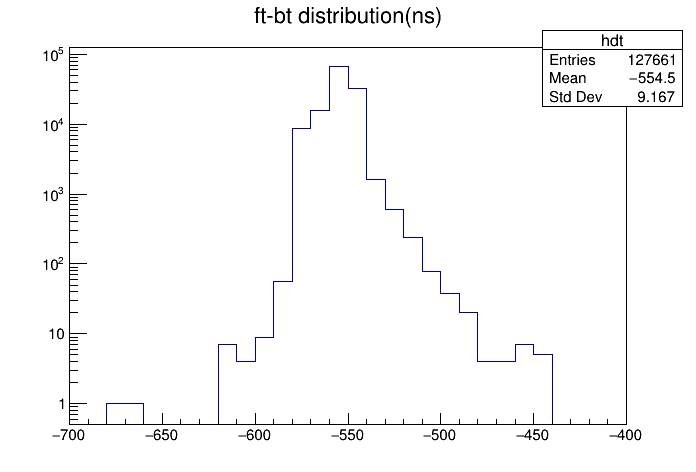

In [2]:
TH1I *hdt = (TH1I*)ipf->Get("hdt");
hdt->GetXaxis()->SetRangeUser(-700, -400);
hdt->Draw();
c1->SetLogy();
c1->Draw();

所以确定时间窗宽度为100，偏移为-550。据此对正背面事件关联

### 正背面能量关联
根据时间对齐对正背面能量关联

```c++
int DSSD::hecorr(int tw, int toff) {
	TH2D *hec = new TH2D("heCorr", "front-back energy correlation", 3000, 0, 30000, 3000, 0, 30000);
	for (auto ift = mapfs.begin(); ift != mapfs.end(); ++ift) {
		auto ibt = mapbs.lower_bound(ift->first-toff-tw);
		for (; ibt != mapbs.end(); ++ibt) {
			if (ibt->first >= ift->first-toff+tw) break;
			hec->Fill(ift->second.Energy, ibt->second.Energy);
		}
	}
	hec->Write();
	return 0;
}

```

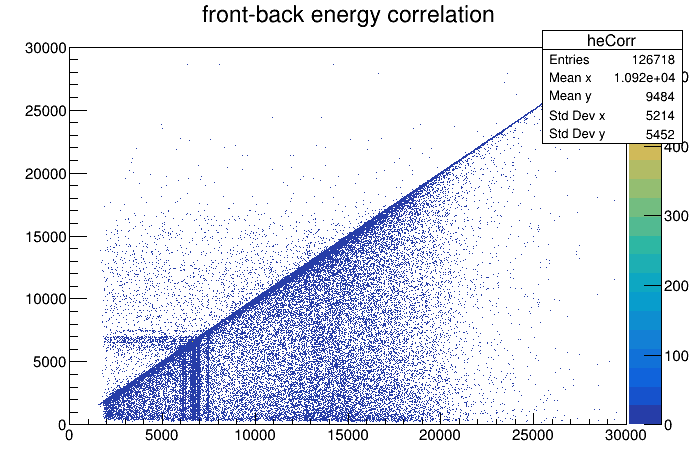

In [3]:
TH2D *hec = (TH2D*)ipf->Get("heCorr");
hec->Draw("colz");
c1->SetLogy(0);
c1->Draw();

发现有不少的条间事件，并且需要对能量进行限制

## 相邻条

### 分析事件数

```c++
int DSSD::getHit(int tw, int toff) {
	dssdInfo *ds[10];
	TH1I *hfhit = new TH1I("hfhit", "hit", 10, 0, 10);
	TH1I *hbhit = new TH1I("hbhit", "hit", 10, 0, 10);
	TH1I *hfdt = new TH1I("hfdt", "dt", 20, -200, 200);
	TH1I *hbdt = new TH1I("hbdt", "dt", 20, -200, 200);
	for (auto ift = mapfs.begin(); ift != mapfs.end(); ++ift) {
		int hit = 0;
		Double_t t0 = 0.0;
		auto jft = mapfs.lower_bound(ift->first-toff);
		for (; jft != mapfs.end(); ++jft) {
			if (jft->first >= ift->first-toff+tw) break;
			if (hit == 0) t0 = jft->first;
			else if (hit == 1) t0 = jft->first - t0;
			if (hit < 10) ds[hit] = &(jft->second);
			++hit;
		}
		if (hit == 2) hfdt->Fill(t0);
		hfhit->Fill(hit);
		for (int i = 0; i != hit && i != 10; ++i) {
			ds[i]->Hit = hit;
			ds[i]->Index = i;
		}
	}

	for (auto ibt = mapbs.begin(); ibt != mapbs.end(); ++ibt) {
		int hit = 0;
		Double_t t0 = 0.0;
		auto jbt = mapbs.lower_bound(ibt->first-toff);
		for (; jbt != mapbs.end(); ++jbt) {
			if (jbt->first >= ibt->first-toff+tw) break;
			if (hit == 0) t0 = jbt->first;
			else if (hit == 1) t0 = jbt->first - t0;
			if (hit < 10) ds[hit] = &(jbt->second);
			++hit;
		}
		if (hit == 2) hbdt->Fill(t0);
		hbhit->Fill(hit);
		for (int i = 0; i != hit && i != 10; ++i) {
			ds[i]->Hit = hit;
			ds[i]->Index = i;
		}
	}

	hfhit->Write();
	hbhit->Write();
	hfdt->Write();
	hbdt->Write();
	return 0;
}
```

#### 正面hit

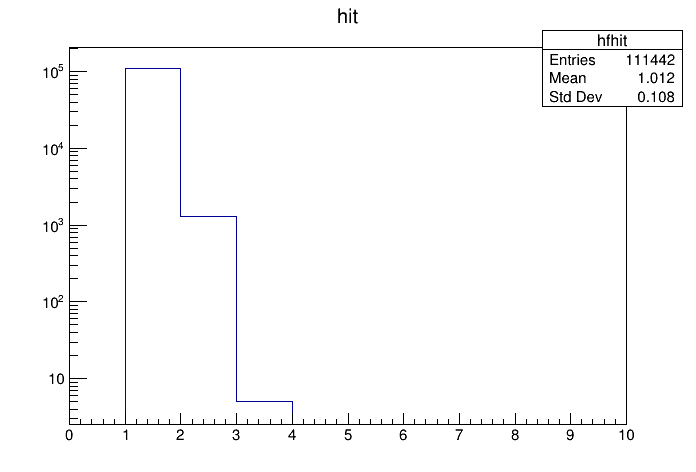

In [4]:
TH1I *hfhit = (TH1I*)ipf->Get("hfhit");
hfhit->Draw();
c1->SetLogy();
c1->Draw();

#### 背面hit

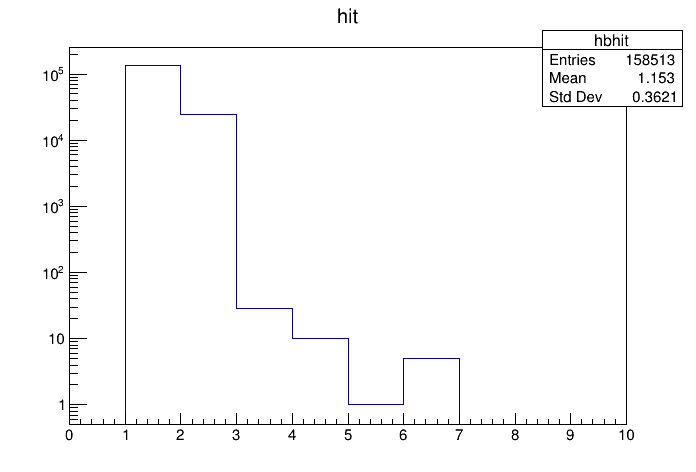

In [5]:
TH1I *hbhit = (TH1I*)ipf->Get("hbhit");
hbhit->Draw();
c1->SetLogy();
c1->Draw();

可以发现背面的多粒子事件更多，因为背面的条更密，容易理解。另外正背面的hit大部分是1，正面只有少量2，背面2的事件数量可观，但是无论正背面大于2的事件都很少，可以忽略。所以只需要考虑hit为1或者2的事件

### 正（背）面相邻条事件的时间符合窗

使用和正背面时间窗一样的方法，但单独对正面或者背面进行选择

#### 正面

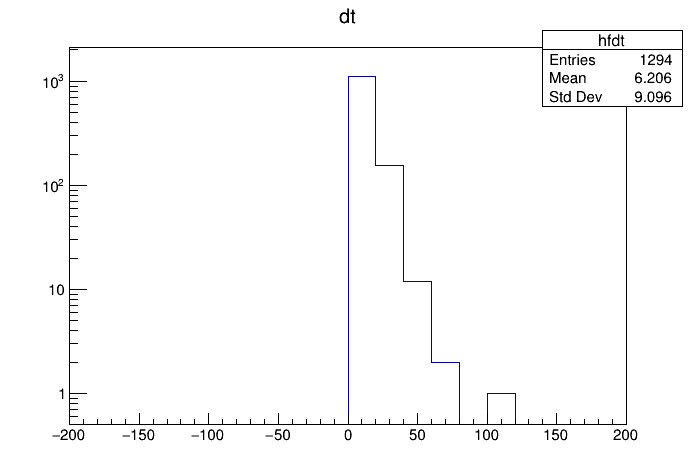

In [6]:
TH1I *hfdt = (TH1I*)ipf->Get("hfdt");
hfdt->Draw();
c1->Draw();

#### 背面

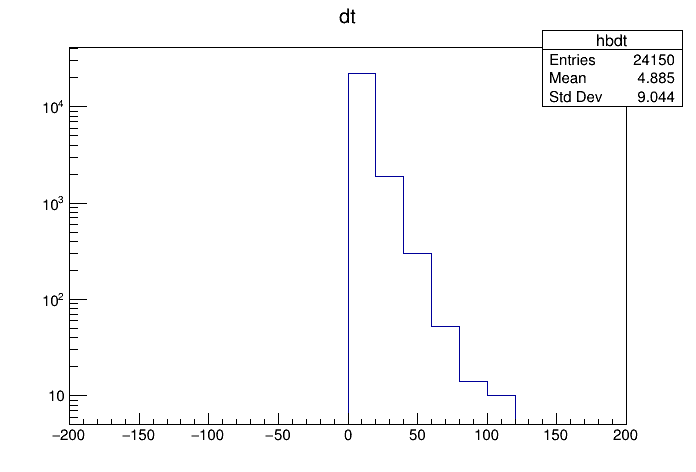

In [7]:
TH1I *hbdt = (TH1I*)ipf->Get("hbdt");
hbdt->Draw();
c1->Draw();

由此，单面的符合时间窗可以考虑为100，偏移为0。

## 处理相邻条

```c++
int DSSD::correlation(int tw, int toff) {
	const int eThre = 50;
	multimap<Double_t, dsfbInfo> mapfbs;
	dsfbInfo dsfb;
	TH2D *hxyse = new TH2D("hxyse", "fse-bse : fse", 2000, -1000, 1000, 3000, 0, 30000);
	TH2D *hxyec = new TH2D("hxyec", "front-back correclation energy", 3000, 0, 30000, 3000, 0, 30000);

	dssdInfo *dsf[2], *dsb[2];
	dsf[0] = dsf[1] = dsb[0] = dsb[1] = nullptr;
	Double_t ft[2];
	for (auto ift = mapfs.begin(); ift != mapfs.end(); ++ift) {

		// front loop
		int fhit = ift->second.Hit;

		if (fhit > 2) continue;
		// fhit == 1 or 2
		dsf[0] = &(ift->second);
		ft[0] = ift->first;
		dsfb.Time = ft[0];
		dsfb.FStrip = dsf[0]->Strip;
		Double_t fse = dsf[0]->Energy;		// front sum energy
		if (fhit == 2) {					// front hit == 2
			++ift;
			dsf[1] = &(ift->second);
			ft[1] = ift->first;
			fse += dsf[1]->Energy;

			// sort by energy
			if (dsf[1]->Energy > dsf[0]->Energy) {
				dsf[1] = dsf[0];
				dsf[0] = &(ift->second);
				ft[1] = ft[0];
				ft[0] = ift->first;
				dsfb.Time = ft[0];
				dsfb.FStrip = dsf[0]->Strip;
			}
		}

		// back loop
		auto ibt = mapbs.lower_bound(ft[0]-toff-tw);
		for (; ibt != mapbs.end(); ++ibt) {
			if (ibt->first >= ft[0]-toff+tw) break;
			mapfbs.clear();

			dsb[0] = &(ibt->second);
			dsfb.BStrip = dsb[0]->Strip;
			Double_t bse = dsb[0]->Energy;

			if (dsb[0]->Hit == 1) {						// bhit == 1
				hxyse->Fill(fse-bse, fse);
				if (abs(fse - bse) < eThre) {				// energy correlation
					if (fhit == 1) {										// f1b1t1
						dsfb.FEnergy = fse;
						dsfb.BEnergy = bse;
						Double_t maxe = fse > bse ? fse : bse;
						mapfbs.insert(make_pair(maxe, dsfb));
						hxyec->Fill(fse, bse);
					} else {												// f2b1t1
						if (abs(dsf[0]->Strip - dsf[1]->Strip) == 1) {				// front pair
							dsfb.FStrip += (dsf[1]->Strip-dsf[0]->Strip) * dsf[1]->Energy / fse;
							dsfb.FEnergy = fse;
							dsfb.BEnergy = bse;
							Double_t maxe = fse > bse ? fse : bse;
							mapfbs.insert(make_pair(maxe, dsfb));
							hxyec->Fill(fse, bse);
						}
					}
				} else {
					continue;								// different energy, jump
				}
			} else {									// bhit == 2
				++ibt;
				dsb[1] = &(ibt->second);
				bse += dsb[1]->Energy;

				// sort by energy
				if (dsb[1]->Energy > dsb[0]->Energy) {
					dsb[1] = dsb[0];
					dsb[0] = &(ibt->second);
					dsfb.BStrip = dsb[0]->Strip;
				}

				hxyse->Fill(fse-bse, fse);

				if (abs(fse - bse) < eThre) {				// energy correlation
					// whether is pari strips, but 2 particles, f2b2t2
					if (fhit == 2 && abs(dsf[0]->Energy-dsb[0]->Energy) < eThre && abs(dsf[1]->Energy-dsb[1]->Energy) < eThre) {
						for (int i = 0; i != 2; ++i) {
							dsfb.Time = ft[0];
							dsfb.FStrip = dsf[i]->Strip;
							dsfb.BStrip = dsb[i]->Strip;
							dsfb.FEnergy = dsf[i]->Energy;
							dsfb.BEnergy = dsb[i]->Energy;
							Double_t maxe = dsf[i]->Energy > dsb[i]->Energy ? dsf[i]->Energy : dsb[i]->Energy;
							mapfbs.insert(make_pair(maxe, dsfb));
							hxyec->Fill(dsf[i]->Energy, dsb[i]->Energy);
						}
					} else if (abs(dsb[0]->Strip - dsb[1]->Strip) == 1) {					// back pair
						if (fhit == 1) {									// f1b2t1
							dsfb.BStrip += (dsb[1]->Strip - dsb[0]->Strip) * dsb[1]->Energy / bse;
							dsfb.FEnergy = fse;
							dsfb.BEnergy = bse;
							Double_t maxe = fse > bse ? fse : bse;
							mapfbs.insert(make_pair(maxe, dsfb));
							hxyec->Fill(fse, bse);
						}
						if (fhit == 2 && abs(dsf[0]->Strip - dsf[1]->Strip) == 1) {			// f2b2t1
							// one particle, but both front and back pair strips
							dsfb.BStrip += (dsb[1]->Strip - dsb[0]->Strip) * dsb[1]->Energy / bse;
							dsfb.FEnergy = fse;
							dsfb.BEnergy = bse;
							Double_t maxe = fse > bse ? fse : bse;
							mapfbs.insert(make_pair(maxe, dsfb));
							hxyec->Fill(fse, bse);
						}
					}
				} else {									// energy different, jump
					continue;
				}

			}

			chit = 0;
			for (auto ifbt = mapfbs.begin(); ifbt != mapfbs.end(); ++ifbt) {
				cEnergy[chit] = ifbt->first;
				cTime[chit] = ifbt->second.Time;
				cfStrip[chit] = ifbt->second.FStrip;
				cbStrip[chit] = ifbt->second.BStrip;
				cfe[chit] = ifbt->second.FEnergy;
				cbe[chit] = ifbt->second.BEnergy;
				++chit;
			}
			opt->Fill();
		}
	}

	hxyse->Write();
	hxyec->Write();
	opt->Write();
	return 0;
}
```

## 正背面能量关联

### 能量窗口

考察正背面的总能量的差值

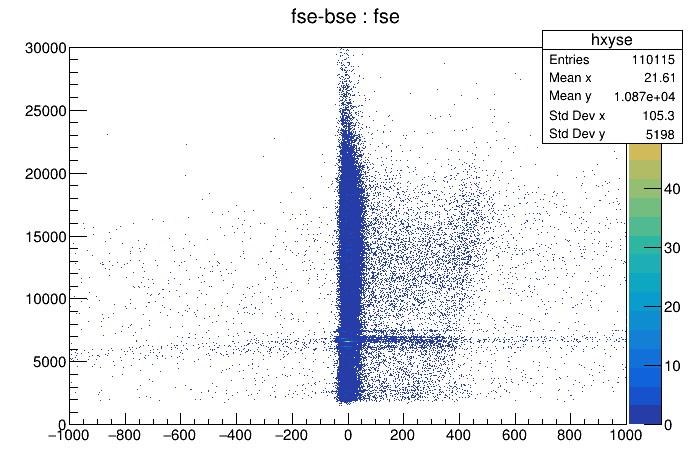

In [8]:
TH2D *hxyse = (TH2D*)ipf->Get("hxyse");
hxyse->Draw("colz");
c1->SetLogy(0);
c1->Draw();

可见能量窗口很窄，这里设置一个严格的能量窗口为差值为50。另外可从图中看出正面的总能量略大于背面，这也是因为背面条数更多，有更多的条间事件，但是靠近条的条间事件分出的另一部分能量太小会被阈值卡掉，所以图中右边有很多散点。

### 能量关联

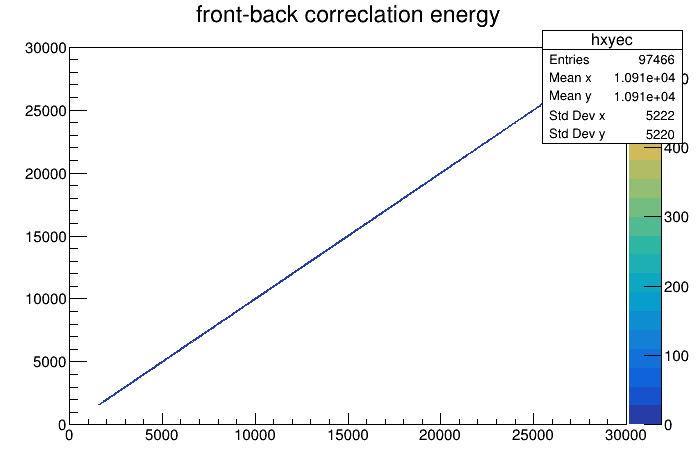

In [9]:
TH2D *hxyec = (TH2D*)ipf->Get("hxyec");
hxyec->Draw("colz");
c1->Draw();

正背面有比较好的关联关系，这也和取的能量窗口非常窄有关。

## 填到TTree中

In [10]:
TTree *tree = (TTree*)ipf->Get("tree");
tree->Print();

******************************************************************************
*Tree    :tree      : dssd after front-back correlation                      *
*Entries :    97454 : Total =         7439847 bytes  File  Size =    4078470 *
*        :          : Tree compression factor =   1.82                       *
******************************************************************************
*Br    0 :hit       : hit/I                                                  *
*Entries :    97454 : Total  Size=     391283 bytes  File Size  =       3334 *
*Baskets :       13 : Basket Size=      32000 bytes  Compression= 117.19     *
*............................................................................*
*Br    1 :e         : e[hit]/D                                               *
*Entries :    97454 : Total  Size=    1174628 bytes  File Size  =     875289 *
*Baskets :       49 : Basket Size=      32000 bytes  Compression=   1.34     *
*...................................................